LCA Percentage Change Heatmap Tool
This script creates a heatmap of percentage changes relative to a base case
with impact categories on Y-axis and scenarios on X-axis
Please upload your '*_all_impacts.csv' files for all scenarios you want to compare...


Saving Basecase_all_impacts.csv to Basecase_all_impacts.csv
Saving Low_Yield_Scenario_all_impacts.csv to Low_Yield_Scenario_all_impacts.csv
Saving Wind_Energy_Scenario_all_impacts.csv to Wind_Energy_Scenario_all_impacts.csv
Loading scenario: Basecase from Basecase_all_impacts.csv
Loading scenario: Low_Yield_Scenario from Low_Yield_Scenario_all_impacts.csv
Loading scenario: Wind_Energy_Scenario from Wind_Energy_Scenario_all_impacts.csv

Loaded 3 scenarios: Basecase, Low_Yield_Scenario, Wind_Energy_Scenario

Select a base case scenario for percentage change calculations:
1. Basecase
2. Low_Yield_Scenario
3. Wind_Energy_Scenario
1
Using 'Basecase' as the base case

Would you like to customize the base case name in the visualization? (y/n)
y

Enter a custom name for the base case 'Basecase':
(default: 'Basecase')
Basecase
Base case will be displayed as: 'Basecase'

Do you want the base case name to appear in italic? (y/n)
n

Would you like to customize the scenario names in the visualizati

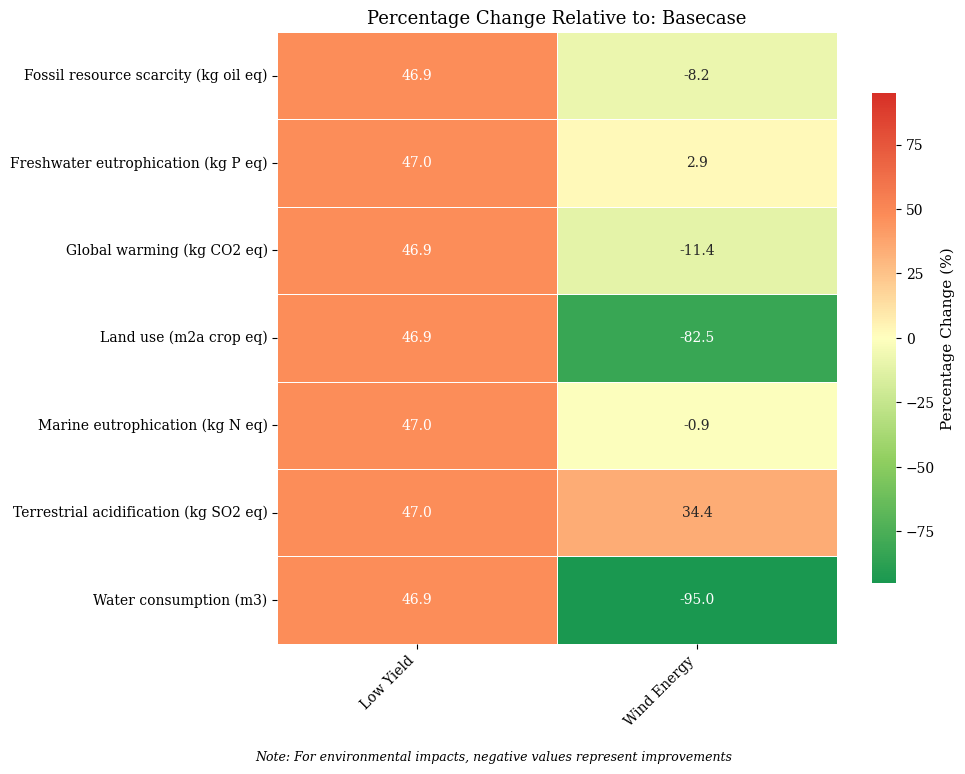


Visualization complete! Saved to lca_percentage_heatmap.png

For Microsoft Word: For best results, insert the image in Word and set the layout to 'In line with text'


In [ ]:

"""heatmap.ipynb

"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import os
from google.colab import files
from matplotlib.font_manager import FontProperties
from matplotlib.colors import LinearSegmentedColormap

# Set up better visualization settings
plt.rcParams.update({
    'figure.figsize': (10.0, 8.0),  # Increased for heatmap
    'font.family': 'serif',
    'font.size': 10,
    'axes.labelsize': 11,
    'axes.titlesize': 13,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'legend.fontsize': 9,
    'axes.spines.top': True,
    'axes.spines.right': True,
    'axes.linewidth': 0.5,
    'grid.linestyle': '--',
    'grid.alpha': 0.3,
    'legend.frameon': True,
    'legend.framealpha': 0.7,
    'legend.handlelength': 4.0,
    'savefig.dpi': 600,
    'savefig.bbox': 'tight',
    'savefig.pad_inches': 0.1,
})

# Colorblind-friendly palette
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=[
    '#4C72B0', '#55A868', '#C44E52', '#8172B3',
    '#CCB974', '#64B5CD', '#AD8BC9', '#B0724E'
])

def load_scenario_data():

    # Upload CSV files
    print("Please upload your '*_all_impacts.csv' files for all scenarios you want to compare...")
    uploaded = files.upload()

    # Load each CSV file into a dataframe
    scenarios = {}

    for filename in uploaded.keys():
        # Extract scenario name from filename (remove _all_impacts.csv)
        scenario_name = re.sub(r'_all_impacts\.csv$', '', filename)

        # Load the CSV
        print(f"Loading scenario: {scenario_name} from {filename}")
        try:
            df = pd.read_csv(filename)

            # Basic validation
            required_columns = ['Impact category', 'Unit', 'Total']
            if not all(col in df.columns for col in required_columns):
                print(f"Warning: File {filename} is missing required columns. Skipping.")
                continue

            # Try to convert Total to numeric, handling errors
            df['Total'] = pd.to_numeric(df['Total'], errors='coerce')

            # Drop rows with NaN values in Total
            df = df.dropna(subset=['Total'])

            # Store in scenarios dictionary
            scenarios[scenario_name] = df

        except Exception as e:
            print(f"Error loading {filename}: {e}")
            continue

    return scenarios

def create_percentage_heatmap(scenarios, base_scenario, selected_categories=None,
                             save_fig=True, fig_filename="lca_percentage_heatmap.png",
                             legend_name_mapping=None, italic_scenarios=None,
                             cmap_style='diverging', bounds=None, base_custom_name=None,
                             base_italic=False):

    if base_scenario not in scenarios:
        print(f"Error: Base scenario '{base_scenario}' not found in loaded scenarios.")
        return None

    # If no specific categories are selected, use all available
    if selected_categories is None:
        # Get all unique impact categories
        impact_categories = set()
        for df in scenarios.values():
            impact_categories.update(df['Impact category'])
        selected_categories = sorted(list(impact_categories))

    # Get base case values for each category
    base_df = scenarios[base_scenario]
    base_values = {}

    for category in selected_categories:
        filtered_base = base_df[base_df['Impact category'] == category]
        if not filtered_base.empty:
            base_values[category] = filtered_base['Total'].values[0]

    # Create a DataFrame for the heatmap
    # Format: rows = impact categories, columns = scenarios, values = percentage change
    heatmap_data = {}

    # Initialize with Impact category and Units
    for category in selected_categories:
        if category in base_values and base_values[category] != 0:
            filtered_base = base_df[base_df['Impact category'] == category]
            unit = filtered_base['Unit'].values[0] if 'Unit' in filtered_base.columns else ''
            heatmap_data[category] = {'Unit': unit}

    # Track all scenario names except base
    scenario_names = [name for name in scenarios.keys() if name != base_scenario]

    # Create percentage change data
    for scenario_name in scenario_names:
        df = scenarios[scenario_name]
        display_name = legend_name_mapping.get(scenario_name, scenario_name) if legend_name_mapping else scenario_name

        # Calculate percentage changes for each category
        for category in selected_categories:
            # Skip if category not in base values
            if category not in base_values or base_values[category] == 0:
                continue

            filtered_df = df[df['Impact category'] == category]
            if filtered_df.empty:
                heatmap_data[category][display_name] = np.nan
            else:
                value = filtered_df['Total'].values[0]
                pct_change = ((value - base_values[category]) / base_values[category]) * 100
                heatmap_data[category][display_name] = pct_change

    # Convert to DataFrame with impact categories as index
    heatmap_df = pd.DataFrame.from_dict(heatmap_data, orient='index')

    # Remove the Unit column before plotting but save it for later use
    units = heatmap_df['Unit'].copy()
    heatmap_df = heatmap_df.drop('Unit', axis=1)

    # Check if we have valid data
    if heatmap_df.empty:
        print("No valid data for heatmap. Check that categories exist in the base scenario.")
        return None

    # Determine suitable figure size based on data dimensions
    height = max(8, len(heatmap_df) * 0.5)
    width = max(10, len(heatmap_df.columns) * 0.8)

    # Create figure
    fig, ax = plt.subplots(figsize=(width, height))

    # Create custom colormap
    if cmap_style == 'diverging':
        # Diverging colormap: blue for negative, white for zero, red for positive
        cmap = sns.diverging_palette(240, 10, as_cmap=True)
    elif cmap_style == 'sequential':
        # Sequential colormap: white to blue
        cmap = sns.color_palette("Blues", as_cmap=True)
    elif cmap_style == 'custom':
        # Custom colormap: green for improvement (negative), red for worsening (positive)
        # For environmental impacts, lower values are better
        cmap = LinearSegmentedColormap.from_list(
            'green_white_red',
            [(0, '#1a9850'),     # Dark green (very negative, good)
             (0.25, '#91cf60'),  # Light green (somewhat negative, good)
             (0.5, '#ffffbf'),   # White/yellow (neutral)
             (0.75, '#fc8d59'),  # Light red (somewhat positive, bad)
             (1, '#d73027')]     # Dark red (very positive, bad)
        )
    else:
        # Default to diverging
        cmap = sns.diverging_palette(240, 10, as_cmap=True)

    # Set vmin and vmax for consistent color scale
    if bounds:
        vmin, vmax = bounds
    else:
        # Find min/max values, excluding NaN
        all_values = heatmap_df.values.flatten()
        all_values = all_values[~np.isnan(all_values)]
        if len(all_values) > 0:
            abs_max = max(abs(np.min(all_values)), abs(np.max(all_values)))
            vmin, vmax = -abs_max, abs_max
        else:
            vmin, vmax = -100, 100  # Default if no data

    # Create heatmap with percentage changes
    # Impact categories as rows, scenarios as columns
    heatmap = sns.heatmap(
        heatmap_df,
        annot=True,
        fmt=".1f",  # 1 decimal place
        cmap=cmap,
        center=0,  # Center colormap at 0
        vmin=vmin,
        vmax=vmax,
        cbar_kws={'label': 'Percentage Change (%)', 'shrink': 0.8},
        linewidths=0.5,
        ax=ax
    )

    # Add units to the row labels (y-axis)
    if not units.empty:
        row_labels = [f"{cat} ({units[cat]})" for cat in heatmap_df.index]
        ax.set_yticklabels(row_labels, rotation=0)

    # Apply formatting to column labels (x-axis)
    plt.xticks(rotation=45, ha='right')

    # Apply italic formatting to specified scenarios in the x-axis labels
    if italic_scenarios:
        # Get x-axis tick labels
        x_labels = ax.get_xticklabels()

        for label in x_labels:
            text = label.get_text()
            # Check if this scenario should be italic
            for scenario_name in italic_scenarios:
                mapped_name = legend_name_mapping.get(scenario_name, scenario_name.replace('_', ' ')) if legend_name_mapping else scenario_name.replace('_', ' ')
                if text == mapped_name:
                    label.set_style('italic')
                    break

        ax.set_xticklabels(x_labels)

    # Set plot title with custom base name if provided
    if base_custom_name:
        base_display_name = base_custom_name
    else:
        base_display_name = legend_name_mapping.get(base_scenario, base_scenario.replace('_', ' ')) if legend_name_mapping else base_scenario.replace('_', ' ')

    # Create title with italic base case name if requested
    title = 'Percentage Change Relative to: '
    if base_italic:
        # Handle spaces correctly when using italic formatting
        # Replace spaces with '\ ' to preserve them in math mode
        formatted_name = base_display_name.replace(' ', r'\ ')
        title += r'$\mathit{' + formatted_name + '}$'
    else:
        title += base_display_name

    plt.title(title)

    # Add note about interpretation
    plt.figtext(0.5, 0.01,
                'Note: For environmental impacts, negative values represent improvements',
                ha='center', fontsize=9, style='italic')

    # Apply tight layout with padding
    plt.tight_layout(pad=1.2, rect=[0, 0.03, 1, 0.97])  # Make room for the note at bottom

    # Save figure if requested
    if save_fig:
        plt.savefig(fig_filename, dpi=600, bbox_inches='tight', pad_inches=0.1)
        print(f"Saved heatmap to {fig_filename}")

    return fig

def select_impact_categories(scenarios):


    # Get all unique impact categories
    all_categories = set()
    for df in scenarios.values():
        all_categories.update(df['Impact category'])

    all_categories = sorted(list(all_categories))

    # Print available categories with numbers
    print("\nAvailable impact categories:")
    for i, category in enumerate(all_categories, 1):
        print(f"{i}. {category}")

    # Ask user to select categories
    print("\nSelect categories to visualize (comma-separated numbers, or 'all' for all categories):")
    selection = input()

    if selection.lower() == 'all' or selection.strip() == '':
        print("Using all impact categories.")
        return all_categories

    try:
        # Parse user selection
        selected_indices = [int(idx.strip()) - 1 for idx in selection.split(',')]
        selected_categories = [all_categories[idx] for idx in selected_indices if 0 <= idx < len(all_categories)]

        if not selected_categories:
            print("No valid categories selected. Using all categories.")
            return all_categories

        return selected_categories
    except:
        print("Invalid selection. Using all categories.")
        return all_categories

def main():
    """Main function to run the LCA visualization workflow"""
    print("=" * 50)
    print("LCA Percentage Change Heatmap Tool")
    print("=" * 50)
    print("This script creates a heatmap of percentage changes relative to a base case")
    print("with impact categories on Y-axis and scenarios on X-axis")

    # Load scenario data
    scenarios = load_scenario_data()

    if not scenarios:
        print("No scenario data loaded. Exiting.")
        return

    print(f"\nLoaded {len(scenarios)} scenarios: {', '.join(scenarios.keys())}")

    # Select base case scenario
    print("\nSelect a base case scenario for percentage change calculations:")
    for i, scenario_name in enumerate(scenarios.keys(), 1):
        print(f"{i}. {scenario_name}")

    try:
        base_idx = int(input().strip()) - 1
        base_scenario = list(scenarios.keys())[base_idx]
        print(f"Using '{base_scenario}' as the base case")
    except:
        print("Invalid selection. Exiting.")
        return

    # Add base case customization
    base_custom_name = None
    base_italic = False
    print("\nWould you like to customize the base case name in the visualization? (y/n)")
    if input().lower().strip() in ['y', 'yes']:
        print(f"\nEnter a custom name for the base case '{base_scenario}':")
        print(f"(default: '{base_scenario.replace('_', ' ')}')")
        custom_name = input().strip()
        if custom_name:  # Only use custom name if user entered something
            base_custom_name = custom_name
            print(f"Base case will be displayed as: '{base_custom_name}'")

        print(f"\nDo you want the base case name to appear in italic? (y/n)")
        italic_choice = input().lower().strip()
        if italic_choice in ['y', 'yes']:
            base_italic = True
            print("Base case name will appear in italic.")

    # Allow user to customize scenario names for display
    legend_mapping = {}
    italic_scenarios = []

    print("\nWould you like to customize the scenario names in the visualization? (y/n)")
    if input().lower().strip() in ['y', 'yes']:
        print("\nFor each scenario, enter the display name you want to use.")
        print("Press Enter to keep the original name (with underscores replaced by spaces).")

        for scenario_name in scenarios.keys():
            if scenario_name == base_scenario:
                continue  # Skip base scenario as it's handled differently

            print(f"Display name for '{scenario_name}' (default: '{scenario_name.replace('_', ' ')}'):")
            display_name = input().strip()
            if display_name:  # Only add to mapping if user entered something
                legend_mapping[scenario_name] = display_name

            print(f"Do you want '{scenario_name}' to appear in italic? (y/n)")
            italic_choice = input().lower().strip()
            if italic_choice in ['y', 'yes']:
                italic_scenarios.append(scenario_name)

    # Select impact categories
    selected_categories = select_impact_categories(scenarios)
    print(f"\nSelected {len(selected_categories)} categories for visualization")

    # Select colormap style
    print("\nSelect colormap style:")
    print("1. Diverging (blue-white-red, centered at zero)")
    print("2. Green-Yellow-Red (green = improvement, red = worsening)")
    print("3. Sequential (white to blue)")

    cmap_style = 'diverging'  # Default
    cmap_choice = input().strip()
    if cmap_choice == '2':
        cmap_style = 'custom'
    elif cmap_choice == '3':
        cmap_style = 'sequential'

    # Set custom bounds for color scale?
    bounds = None
    print("\nWould you like to set custom bounds for the color scale? (y/n)")
    print("(This helps when comparing multiple visualizations)")
    if input().lower().strip() in ['y', 'yes']:
        try:
            print("Enter minimum percentage value:")
            min_val = float(input().strip())
            print("Enter maximum percentage value:")
            max_val = float(input().strip())
            bounds = (min_val, max_val)
        except:
            print("Invalid input. Using automatic scaling.")

    # Set default filename
    fig_filename = "lca_percentage_heatmap.png"

    # Generate heatmap
    print("\nGenerating percentage change heatmap...")
    fig = create_percentage_heatmap(
        scenarios,
        base_scenario,
        selected_categories=selected_categories,
        save_fig=True,
        fig_filename=fig_filename,
        legend_name_mapping=legend_mapping,
        italic_scenarios=italic_scenarios,
        cmap_style=cmap_style,
        bounds=bounds,
        base_custom_name=base_custom_name,
        base_italic=base_italic
    )

    if fig:
        plt.show()
        print(f"\nVisualization complete! Saved to {fig_filename}")
        print("\nFor Microsoft Word: For best results, insert the image in Word and set the layout to 'In line with text'")
    else:
        print("\nVisualization failed. Please check your data.")

if __name__ == "__main__":
    main()